In [7]:
!pip install pfhedge

  Using cached pfhedge-0.23.0-py3-none-any.whl.metadata (805 bytes)
Using cached pfhedge-0.23.0-py3-none-any.whl (105 kB)

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [14]:
import torch
import torch.nn.functional as fn
from torch import Tensor
from torch.nn import Module
import matplotlib.pyplot as plt

In [9]:
from pfhedge.instruments import BrownianStock
from pfhedge.instruments import EuropeanOption

stock = BrownianStock(cost=0, mu=0.05)
derivative = EuropeanOption(stock, maturity=1)

derivative

EuropeanOption(
  strike=1., maturity=1
  (underlier): BrownianStock(sigma=0.2000, mu=0.0500, dt=0.0040)
)

In [10]:
from pfhedge.nn import BlackScholes
from pfhedge.nn import Clamp
from pfhedge.nn import Hedger
from pfhedge.nn import MultiLayerPerceptron
from pfhedge.nn import EntropicRiskMeasure

new_loss = EntropicRiskMeasure(a=0.000001)

model = MultiLayerPerceptron()
hedger = Hedger(model, inputs=["log_moneyness", "expiry_time", "volatility", "prev_hedge"], criterion=new_loss)

hedger

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Hedger(
  inputs=['log_moneyness', 'expiry_time', 'volatility', 'prev_hedge']
  (model): MultiLayerPerceptron(
    (0): LazyLinear(in_features=0, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=1, bias=True)
    (9): Identity()
  )
  (criterion): EntropicRiskMeasure(a=1.0000e-06)
)

In [11]:
loss_obs = hedger.fit(derivative, n_epochs=200)

Loss=-5516.5293: 100%|██████████| 200/200 [01:32<00:00,  2.15it/s]


In [16]:
loss_obs

[0.476837158203125,
 0.0,
 0.476837158203125,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.476837158203125,
 0.0,
 0.0,
 0.476837158203125,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.476837158203125,
 0.476837158203125,
 0.476837158203125,
 0.476837158203125,
 0.476837158203125,
 0.476837158203125,
 0.476837158203125,
 0.476837158203125,
 0.476837158203125,
 0.476837158203125,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.476837158203125,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.476837158203125,
 -1.430511474609375,
 -6.67572021484375,
 -1044.750244140625,
 81337760.0,
 -1182.079345703125,
 -9.059906005859375,
 -2.384185791015625,
 -1.430511474609375,
 -0.95367431640625,
 -0.95367431640625,
 -0.476837158203125,
 -0.476837158203125,
 -0.95367431640625,
 -0.476837158203125,
 -0.476837158203125,
 0.0,
 -0.476837158203125,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.476837158203125,
 -0.476837158203125,
 0.0,
 0.0,
 0.0,
 -0.47683715

(-6000.0, 100.0)

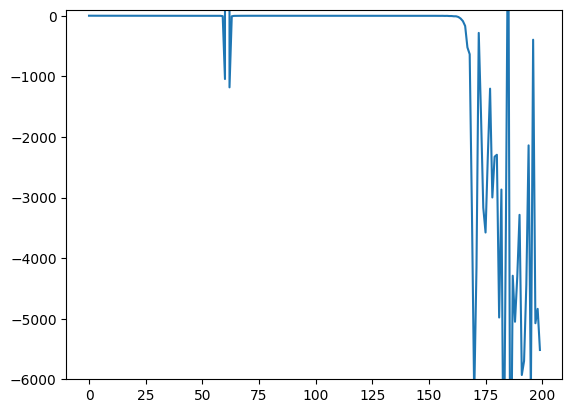

In [20]:
plt.plot(loss_obs)
plt.ylim((-6000,100))

In [12]:
price = hedger.price(derivative)
price

tensor(-1797.6761)

In [24]:
class NoTransactionBandNet(Module):
    def __init__(self, derivative):
        super().__init__()

        self.delta = BlackScholes(derivative)
        self.mlp = MultiLayerPerceptron(out_features=2)
        self.clamp = Clamp()

    def inputs(self):
        return self.delta.inputs() + ["prev_hedge"]

    def forward(self, input: Tensor) -> Tensor:
        prev_hedge = input[..., [-1]]

        delta = self.delta(input[..., :-1])
        width = self.mlp(input[..., :-1])

        min = delta - fn.leaky_relu(width[..., [0]])
        max = delta + fn.leaky_relu(width[..., [1]])

        return self.clamp(prev_hedge, min=min, max=max)


model = NoTransactionBandNet(derivative)
hedger = Hedger(model, inputs=model.inputs())

hedger.fit(derivative, n_epochs=200)

Loss=0.0763: 100%|██████████| 200/200 [03:43<00:00,  1.12s/it]


[0.09912919998168945,
 0.09762144088745117,
 0.09670019149780273,
 0.09656286239624023,
 0.09612655639648438,
 0.09302234649658203,
 0.0930624008178711,
 0.09243440628051758,
 0.09090042114257812,
 0.0909423828125,
 0.09110641479492188,
 0.09015464782714844,
 0.09117460250854492,
 0.08982086181640625,
 0.08956098556518555,
 0.08975648880004883,
 0.08708906173706055,
 0.08681011199951172,
 0.08646631240844727,
 0.08888435363769531,
 0.0877389907836914,
 0.08846902847290039,
 0.08611202239990234,
 0.08562183380126953,
 0.08659029006958008,
 0.08589506149291992,
 0.0845341682434082,
 0.08342599868774414,
 0.08419990539550781,
 0.08416557312011719,
 0.0851750373840332,
 0.08219194412231445,
 0.0851888656616211,
 0.08205413818359375,
 0.08217430114746094,
 0.08345937728881836,
 0.0824289321899414,
 0.08077859878540039,
 0.0798029899597168,
 0.08285188674926758,
 0.08067512512207031,
 0.08088350296020508,
 0.0828862190246582,
 0.08158159255981445,
 0.08082914352416992,
 0.07944917678833008,


In [25]:
price = hedger.price(derivative)
price

tensor(0.0813)

In [3]:
import torch

In [1]:
from pfhedge.instruments import BrownianStock
from pfhedge.instruments import EuropeanOption
from pfhedge.nn import BlackScholes
from pfhedge.nn import Hedger


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/runpy.py", line 198, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/runpy.py", line 88, in _run_code
    exec(code, run_globals)
  File "/Users/julesarzel/Library/Python/3.12/lib/python/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/julesarzel/Library/Python/3.12/lib/python/site-packages/traitlets/c

In [5]:
torch.manual_seed(42)

# Prepare a derivative to hedge
derivative = EuropeanOption(BrownianStock(cost=1e-4), maturity=1)

# Create your hedger
model = BlackScholes(derivative)
hedger = Hedger(model, model.inputs())

# Fit and price
price = hedger.price(derivative, n_paths=10000)
print(f"Price={price:.5e}")

Price=8.02164e-02
